## Comparison Between Methods

We compare three approaches for updating the process noise parameter \( Q \):

---

**1. BCUC (ours)** – Based on quantile coupling, inspired by CUQDS:  

The quantile $q$ is updated using a proportional–control (P-controller) rule:  
$q_{\text{new}} = q + \eta \, (\bar{E} - \alpha)$  

Then, $Q$ is updated via:  
$Q \leftarrow q^2 \, Q$

---

**2. Conformal Prediction style** – The quantile $q$ is computed as the empirical quantile of the maintained scores:  
$
q \leftarrow \mathrm{Quantile}(\{\text{scores}\}, \, 1 - \alpha)
$  

Then, $Q$ is updated using the same formula as in method 1:  
$
Q \leftarrow q^2 \, Q
$

---

**3. NLL-gradient based** – $Q$ is updated directly by taking a gradient step on the negative log-likelihood (NLL):  

$Q \leftarrow Q - \eta \, \frac{\partial \,\mathrm{NLL}}{\partial Q}$

---


In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import os
sys.path.append(os.path.abspath("../../"))  # or "." or ".." depending on your structure

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from models.model_utils import mask_observations, params
from models.linear_model import LinearModel_Estimator
from calibrator_module.BCUC_calibrator_finalVersion import BCUC_Calibrator
from models.model_utils import paramsw
from calibrator_module.NLL_gradient_descent_calibrator import NLLBasedQCalibrator
from calibrator_module.conformal_prediction_classic import conformalPrediction_Calibrator

In [39]:

!python ../observation_generation.py --dir_path "../observations" --format npz --n_steps 10000

4732.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Creating linear system...
[[0.3]]

Generating observations for random_zeros_and_actions actions...
Generated 10001 observations
Observation shape: (1,)
Data saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000.npz
Model parameters saved as ../observations/observations_random_zeros_and_actions_for_Q0.3_steps_10000_params.json
Observation mean: [4.85750018]
Observation std: [1.76903086]
Observation generation complete!

Recommended workflow:
1. Use .npz format for numerical analysis in Python
2. Use .csv format for analysis in Excel or pandas
3. Use .json format for human-readable debugging
4. Use .mat format for MATLAB interoperability


In [29]:
# --- Load data ---
from models.model_utils import params
persons = [0.01, 0.3, 0.7, 1.5]
initial_model = LinearModel_Estimator(**params)
print(f"Initial Q matrix: {initial_model.Q}")


calibrators_BCUC = []
calibrators_conformalPred = []
calibrators_nll = []

calibrated_models_BCUC = []
calibrated_models_conformalPred = []
calibrated_models_nll = []

metrics_BCUC = []
metrics_conformalPred = []
metrics_nll = []

# --
for person in persons:
    path_to_load = f"../../observations/observations_random_zeros_and_actions_for_Q{person}_steps_10000.npz"
    data = np.load(path_to_load, allow_pickle=True)
    masked_observations = mask_observations(data['observations'])
    actions = data['actions']

    # --- build models ---
    to_print = f"Target (true) Q*: {person}"
    print(to_print)
    
    cal_qc = BCUC_Calibrator(
        initial_model=initial_model,
        alpha=0.32,          # μ±σ target; keeps Q identification unbiased if Gaussian
    )
    model_qc = cal_qc.calibrate_model(masked_observations, actions)
    calibrated_models_BCUC.append(model_qc)
    calibrators_BCUC.append(cal_qc)

    cal_cp = conformalPrediction_Calibrator(
    initial_model=initial_model,
    update_after_every=15
    )
    
    model_cp = cal_cp.calibrate_model(masked_observations, actions)
    calibrated_models_conformalPred.append(model_cp)
    calibrators_conformalPred.append(cal_cp)

    cal_nll = NLLBasedQCalibrator(
    initial_model=initial_model,
    update_after_every=15
    )
    
    model_nll = cal_nll.calibrate_model(masked_observations, actions)
    calibrated_models_conformalPred.append(model_nll)
    calibrators_nll.append(cal_nll)
    
    NLLBasedQCalibrator
    # --- evaluate metrics ---
    metrics_qc = cal_qc.get_metrics(person)
    metrics_BCUC.append(metrics_qc)
    metrics_cp = cal_cp.get_metrics(person)
    metrics_conformalPred.append(metrics_cp)
    metrics_nll_dict = cal_nll.get_metrics(person)
    metrics_nll.append(metrics_nll_dict)
    
    # --- print results ---
    print("[BCUC quantile_coupled]")
    print("metrics:", metrics_qc)
    print("final Q:", model_qc.Q)
    print()
    print("[Conformal Prediction quantile_coupled Threshold Calibrator]")
    print("metrics:", metrics_cp)
    print("final Q:", model_cp.Q)
    print()
    print("[NLL Based Q Calibrator]")
    print("metrics:", metrics_nll_dict)
    print("final Q:", model_nll.Q)
    print()

Initial Q matrix: [[0.6275]]
Target (true) Q*: 0.01
[BCUC quantile_coupled]
metrics: {'E_bar': 0.28554979850316636, 'coverage': 0.7144502014968337, 'mean_interval_width': 0.3351726108909286, 'avg_nll': -0.9813455934013139, 'final_difference': 0.014743392780994844, 'relative_error': 1.4743392780994844}
final Q: [[0.02474339]]

[Conformal Prediction quantile_coupled Threshold Calibrator]
metrics: {'E_bar': 0.5372769142199194, 'coverage': 0.4627230857800806, 'mean_interval_width': 0.23417284609269337, 'avg_nll': -1.269300151057989, 'final_difference': 0.0014279868392486801, 'relative_error': 0.142798683924868}
final Q: [[0.00857201]]

[NLL Based Q Calibrator]
metrics: {'E_bar': 0.0012953367875647714, 'coverage': 0.9987046632124352, 'mean_interval_width': 0.3533854858359815, 'avg_nll': -0.851649895836008, 'final_difference': 0.06371623015568616, 'relative_error': 6.371623015568615}
final Q: [[0.07371623]]

Target (true) Q*: 0.3
[BCUC quantile_coupled]
metrics: {'E_bar': 0.31332757628094415

In [48]:
import pandas as pd
metrics_BCUC = pd.DataFrame(metrics_BCUC, index=persons)
metrics_conformalPred = pd.DataFrame(metrics_conformalPred, index=persons)
metrics_nll = pd.DataFrame(metrics_nll, index=persons)
metrics_BCUC

,E_bar,coverage,mean_interval_width,avg_nll,final_difference,relative_error
0.01,0.285550,0.714450,0.335173,-0.981346,0.014743,1.474339
0.30,0.313328,0.686672,0.459550,-0.180632,0.006589,0.021964
0.70,0.313040,0.686960,0.619520,0.217365,0.006556,0.009366
1.50,0.312320,0.687680,0.850473,0.610626,0.026998,0.017999


In [49]:

data = {
    "BCUC": [
        metrics_BCUC["E_bar"].mean(),
        metrics_BCUC["mean_interval_width"].mean(),
        metrics_BCUC["final_difference"].mean(),
        metrics_BCUC["avg_nll"].mean()
    ],
    "Conformal": [
        metrics_conformalPred["E_bar"].mean(),
        metrics_conformalPred["mean_interval_width"].mean(),
        metrics_conformalPred["final_difference"].mean(),
        metrics_conformalPred["avg_nll"].mean()
    ],
    "NLL": [
        metrics_nll["E_bar"].mean(),
        metrics_nll["mean_interval_width"].mean(),
        metrics_nll["final_difference"].mean(),
        metrics_nll["avg_nll"].mean()
    ]
}

df_summary = pd.DataFrame(
    data,
    index=["E_bar_mean", "mean_interval_width_mean", "final_difference_mean", "avg_nll_mean"]
)

print(df_summary)


                              BCUC  Conformal       NLL
E_bar_mean                0.306059   0.376511  0.239026
mean_interval_width_mean  0.566179   0.545284  0.556657
final_difference_mean     0.013722   0.105614  0.052117
avg_nll_mean             -0.083497  -0.153525 -0.043525


In [ ]:
Q_vals_BCUC = [cal.Q_history for cal in calibrators_BCUC]
Q_vals_conformal= [cal.Q_history for cal in calibrators_conformalPred]
Q_vals_nll= [cal.Q_history for cal in calibrators_nll]

q_vals_BCUC = [cal.q_history for cal in calibrators_BCUC]
q_vals_conformal = [cal.q_history for cal in calibrators_conformalPred]


In [31]:
dir_name = "plots/all_together"
os.makedirs(dir_name, exist_ok=True)

## Plots

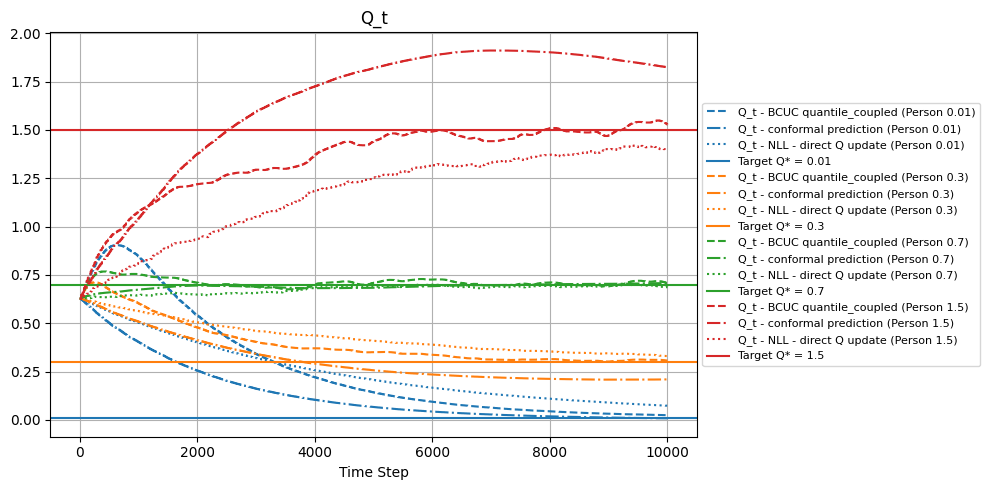

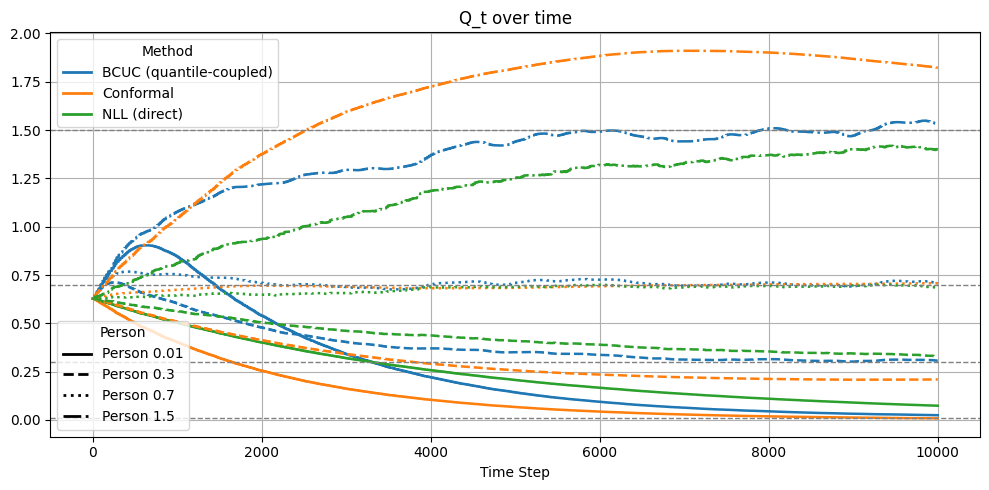

In [52]:
def to_1d_float(seq):
    return np.array([float(np.asarray(v).reshape(-1)[0]) for v in seq], dtype=float)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Time Step")
ax.set_title("Q_t")
ax.grid(True)

for i, (Q_val, Q_val_conformal, Q_val_nll) in enumerate(zip(Q_vals_BCUC, Q_vals_conformal, Q_vals_nll)):
    y  = to_1d_float(Q_val)
    y2 = to_1d_float(Q_val_conformal)
    y3 = to_1d_float(Q_val_nll)

    x  = np.arange(len(y))
    line, = ax.plot(x, y, linewidth=1.5,
                    label=f"Q_t - BCUC quantile_coupled (Person {persons[i]})",
                    linestyle='--')
    color = line.get_color()

    x2 = np.arange(len(y2))
    ax.plot(x2, y2, linewidth=1.5,
            label=f"Q_t - conformal prediction (Person {persons[i]})",
            color=color, linestyle='-.')

    x3 = np.arange(len(y3))
    ax.plot(x3, y3, linewidth=1.5,
            label=f"Q_t - NLL - direct Q update (Person {persons[i]})",
            color=color, linestyle=':')

    ax.axhline(y=float(np.asarray(persons[i]).reshape(-1)[0]),
               color=color, linestyle='-',
               label=f"Target Q* = {persons[i]}")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})
fig.tight_layout()
fig.savefig(os.path.join(dir_name, "Q_t_over_time.png"), dpi=300, bbox_inches='tight')
plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
from itertools import cycle

def _to_1d_float(seq):
    # Coerce each entry to a scalar float; handles 1x1 arrays, lists, etc.
    return np.array([float(np.asarray(v).reshape(-1)[0]) for v in seq], dtype=float)

def plot_Qt(Q_vals_BCUC, Q_vals_conformal, Q_vals_nll, Q_targets, title="Q_t"):
    # --- style maps ---
    colors = {"BCUC": "tab:blue", "Conformal": "tab:orange", "NLL": "tab:green"}
    # cycle linestyles for persons (add more if you have more people)
    ls_list = ["-", "--", ":", "-.", (0,(5,2,1,2))]  # last is custom dash
    person_styles = ls_list if len(Q_vals_BCUC) <= len(ls_list) else ls_list + ["-"]*(len(Q_vals_BCUC)-len(ls_list))

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlabel("Time Step")
    ax.set_title(title)
    ax.grid(True)

    for i, (Q_b, Q_c, Q_n) in enumerate(zip(Q_vals_BCUC, Q_vals_conformal, Q_vals_nll)):
        ls = person_styles[i]
        # coerce to 1D float arrays and align lengths defensively
        y_b  = _to_1d_float(Q_b)
        y_c  = _to_1d_float(Q_c)
        y_n  = _to_1d_float(Q_n)

        x_b = np.arange(len(y_b)); ax.plot(x_b, y_b, color=colors["BCUC"],     linestyle=ls, linewidth=1.8)
        x_c = np.arange(len(y_c)); ax.plot(x_c, y_c, color=colors["Conformal"], linestyle=ls, linewidth=1.8)
        x_n = np.arange(len(y_n)); ax.plot(x_n, y_n, color=colors["NLL"],       linestyle=ls, linewidth=1.8)

        # target line (thin gray so it doesn't dominate)
        q_star = float(np.asarray(Q_targets[i]).reshape(-1)[0])
        ax.axhline(y=q_star, color="0.5", linestyle="--", linewidth=1.0)

    # --- legends: (1) method-by-color, (2) person-by-linestyle ---
    method_handles = [plt.Line2D([0],[0], color=c, lw=2) for c in [colors["BCUC"], colors["Conformal"], colors["NLL"]]]
    method_labels  = ["BCUC (quantile-coupled)", "Conformal", "NLL (direct)"]
    leg1 = ax.legend(method_handles, method_labels, title="Method", loc="upper left")

    person_handles = [plt.Line2D([0],[0], color="black", lw=2, linestyle=ls) for ls in person_styles[:len(Q_vals_BCUC)]]
    person_labels  = [f"Person {p}" for p in Q_targets]  # or use your own labels
    leg2 = ax.legend(person_handles, person_labels, title="Person", loc="lower left")
    ax.add_artist(leg1)  # keep both legends

    # optional: place both legends outside if you prefer
    # leg1 = ax.legend(method_handles, method_labels, title="Method",
    #                  loc='center left', bbox_to_anchor=(1.02, 0.65))
    # ax.add_artist(leg1)
    # leg2 = ax.legend(person_handles, person_labels, title="Person",
    #                  loc='center left', bbox_to_anchor=(1.02, 0.25))

    fig.tight_layout()
    # fig.savefig(os.path.join(dir_name, "Q_t_over_time_clean.png"), dpi=300, bbox_inches='tight')
    plt.show()

# usage (with your existing variables):
# plot_Qt(Q_vals_BCUC, Q_vals_conformal, Q_vals_nll, persons, title="Q_t")

# Call the plotting function
plot_Qt(
    Q_vals_BCUC,        # your BCUC q_t values
    Q_vals_conformal,   # your conformal q_t values
    Q_vals_nll,         # your NLL q_t values
    persons,            # your Q* targets (the same as in your legend)
    title="Q_t over time"
)



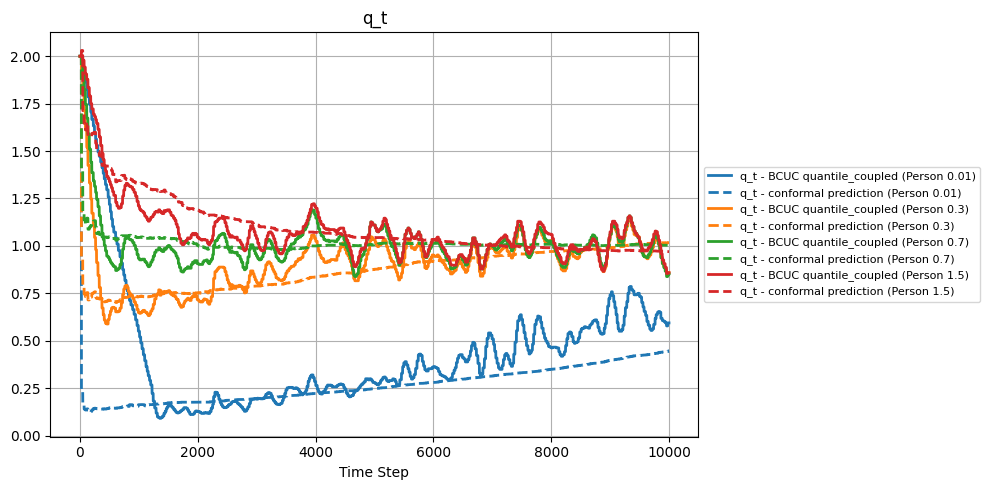

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Time Step")
ax.set_title("q_t")
ax.grid(True)

def to_1d_float(seq):
    # Coerce each entry to a scalar float; handles 1x1 arrays, lists, etc.
    return np.array([float(np.asarray(v).reshape(-1)[0]) for v in seq], dtype=float)

for i, (q_val, q_val_conformal) in enumerate(zip(q_vals_BCUC, q_vals_conformal)):
    y  = to_1d_float(q_val)
    y2 = to_1d_float(q_val_conformal)

    # If lengths differ, align to the shorter to avoid shape errors
    T = min(len(y), len(y2))
    x = np.arange(T)

    line, = ax.plot(x, y[:T], linewidth=2,
                    label=f"q_t - BCUC quantile_coupled (Person {persons[i]})")
    color = line.get_color()

    ax.plot(x, y2[:T], linewidth=2,
            label=f"q_t - conformal prediction (Person {persons[i]})",
            color=color, linestyle='--')

# Legend outside
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

fig.tight_layout()
fig.savefig(os.path.join(dir_name, "q_t_over_time_.png"), dpi=300, bbox_inches='tight')
plt.show()


In [1]:
import numpy as np

mu = 0
var = 0.5
x = 0.1

resid2 = (x - mu)**2
nll = 0.5 * (np.log(2 * np.pi * var) + resid2 / var)
ll = -nll

print("NLL =", nll)
print("LL =", ll)


NLL = 0.5823649429247001
LL = -0.5823649429247001
